# Problem 7: Allometric scaling and pharmacokinetics

The study of pharmacokinetics in medicine seeks the ability to determine the clearance rate $C$ at which a human body removes a drug. 
This is valuable for determining the proper drug to administer a patient, and is particularly crucial for pediatric medicine where there are large ranges of body mass $M$. 

Over decades (and indeed [centuries](https://en.wikipedia.org/wiki/Square%E2%80%93cube_law)) of empirical and theory-driven studies, researchers have determined that power-laws can fit this data,

$ C = k M^\alpha $

where $k$ and $\alpha$ are parameters that depend on the drug.
The value of $\alpha$ has mechanistic meaning, and is typically $\alpha \in (0.6,1.0)$, but many clinical settings use $\alpha=0.75$.
See [Calvier et al, "Allometric Scaling of Clearance in Paediatric Patients" Clinical Pharmacokinetics 2017](https://link.springer.com/article/10.1007/s40262-016-0436-x) and [Valkengoed et al., "All You Need to Know About Allometric Scaling: An Integrative Review on the Theoretical Basis, Empirical Evidence, and Application in Human Pharmacology", Clinical Pharmakokinetics 2025](https://link.springer.com/article/10.1007/s40262-024-01444-6).

The following generates a synthetic dataset of size $N_{\textrm{obs}}$ for $C$ and $M$, assuming a ground truth of $\alpha_{\textrm{GT}}$ and normal random noise with $\sigma$.

Note that the patients sample has uniform random masses. 


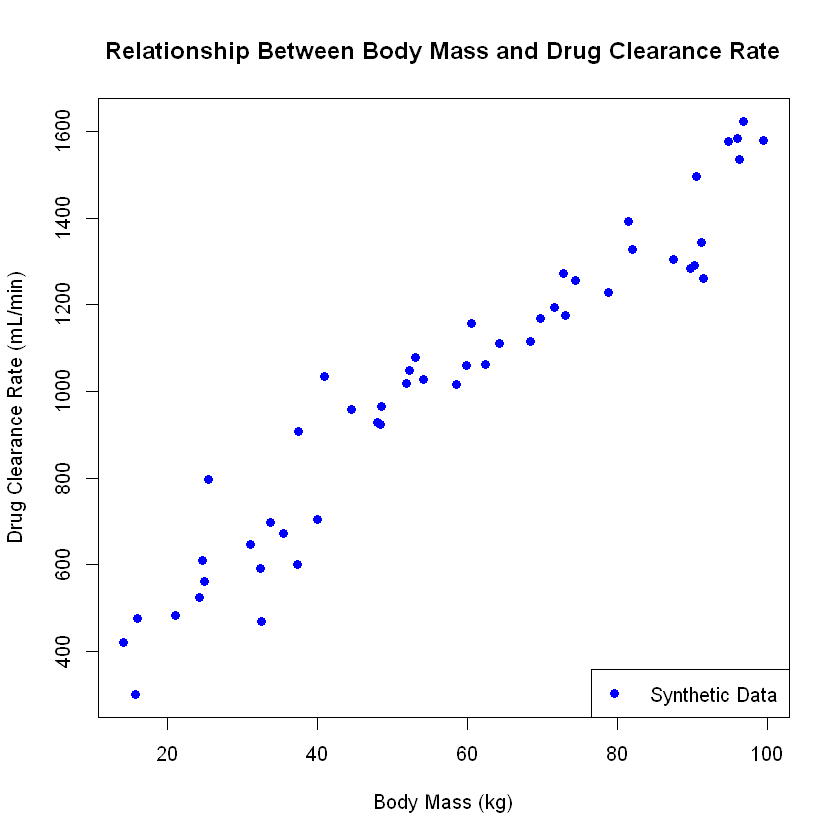

In [6]:
# Set seed for reproducibility
set.seed(123)

# Define parameters
Nobs <- 50
M_min <- 12  # minimum body mass in kg
M_max <- 100 # maximum body mass in kg
alpha_gt <- 0.68
C_min <- 500  # minimum clearance rate in mL/min
C_max <- 1500 # maximum clearance rate in mL/min
sigma <- 100  # standard deviation for the noise (adjust as needed)

# Generate body mass values (uniform distribution)
M <- runif(Nobs, min = M_min, max = M_max)

# Calculate the value of k that will scale clearance rates to the desired range
max_M_alpha <- max(M)^alpha_gt
k_gt <- C_max / max_M_alpha

# Calculate theoretical clearance rates
C_theoretical <- k_gt * M^alpha_gt

# Add noise to the clearance rates
noise <- rnorm(Nobs, mean = 0, sd = sigma)
C_observed <- C_theoretical + noise

# Create a data frame
patient_data <- data.frame(
  PatientID = 1:Nobs,
  BodyMass = M,
  ClearanceRate_Theoretical = C_theoretical,
  ClearanceRate_Observed = C_observed
)

# Print summary statistics
# summary(patient_data)

# Plot the data
par(bg = "white")
plot(patient_data$BodyMass, patient_data$ClearanceRate_Observed,
     xlab = "Body Mass (kg)",
     ylab = "Drug Clearance Rate (mL/min)",
     main = "Relationship Between Body Mass and Drug Clearance Rate",
     pch = 19,
     col = "blue")

# # Add a smooth curve of the theoretical relationship
# curve(k * x^alpha, from = M_min, to = M_max, add = TRUE, col = "red", lwd = 2)

# Add a legend
legend("bottomright", 
       legend = c("Synthetic Data"),
       col = c("blue"),
       pch = c(19, NA),
       lty = c(NA, 1),
       lwd = c(NA, 2))


## Question i

Transform the equation by taking the log. 
Your new equation should be a relationship between $lC = log(x)$ and $log(M)$, and be linear function of $k_1$ and $\alpha$. 

Take the log of the data.
Write code to perform linear regression to estimate $\alpha$.
Call this $\tilde{\alpha}$.


In [7]:
# Take logs of the data
log_M <- log(M)
log_C <- log(C_observed)

# Perform linear regression on the log-transformed data
log_model <- lm(log_C ~ log_M)
alpha_estimated <- coef(log_model)[2]  # Slope corresponds to alpha

# Print results
cat("Ground truth alpha:", alpha_gt, "\n")
cat("Estimated alpha from log-linear regression:", alpha_estimated, "\n")
cat("Absolute error:", abs(alpha_estimated - alpha_gt), "\n")


Ground truth alpha: 0.68 
Estimated alpha from log-linear regression: 0.7185928 
Absolute error: 0.03859283 


Perform a sweep where you vary $\sigma$ and generate a new synthetic dataset.
For each $\sigma$, compute $|\tilde{\alpha} - \alpha_{\textrm{GT}}|$, the true error.
Plot the true error versus $\sigma$. 


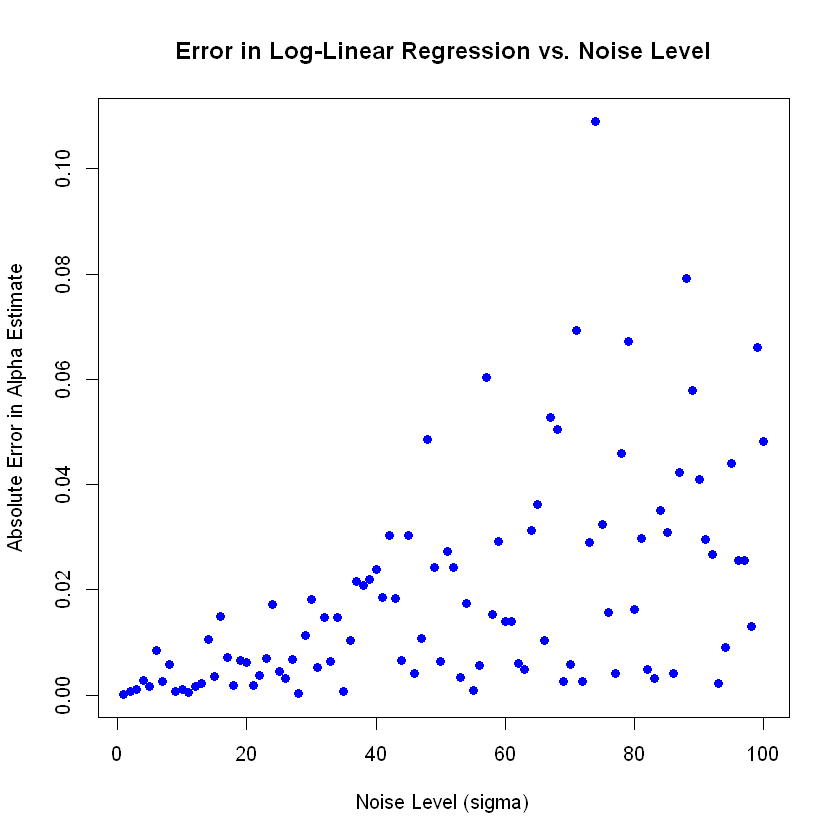

In [8]:
# Perform sweep over different noise levels
sigma_values <- seq(1, 100, by = 1)
error_values_log <- numeric(length(sigma_values))

for (i in 1:length(sigma_values)) {
  current_sigma <- sigma_values[i]
  
  # Generate new noise and observed clearance
  noise <- rnorm(Nobs, mean = 0, sd = current_sigma)
  C_observed <- C_theoretical + noise
  
  # Some noise values might make C_observed negative, which would make log undefined
  # Handle this by using only positive values
  valid_indices <- C_observed > 0
  
  if (sum(valid_indices) < 0.9 * Nobs) {
    # If too many negative values, skip this sigma
    error_values_log[i] <- NA
    next
  }
  
  # Take logs of valid data
  log_M_valid <- log_M[valid_indices]
  log_C_valid <- log(C_observed[valid_indices])
  
  # Fit log-linear model
  log_model <- lm(log_C_valid ~ log_M_valid)
  alpha_estimated <- coef(log_model)[2]
  
  # Calculate error
  error_values_log[i] <- abs(alpha_estimated - alpha_gt)
}

# Plot error vs sigma
par(bg = "white")
plot(sigma_values, error_values_log, 
     type = "p", 
     xlab = "Noise Level (sigma)", 
     ylab = "Absolute Error in Alpha Estimate",
     main = "Error in Log-Linear Regression vs. Noise Level",
     pch = 19,
     col = "blue")


## Question ii
Now, let's perform a nonlinear fit using R's built-in `nls` function.
Do not transform the data. 

In [9]:
# Create data frame for nls
data <- data.frame(M = M, C = C_observed)

# Fit nonlinear model
# Start with reasonable initial values for parameters
nls_model <- nls(C ~ k * M^alpha, data = data, 
                start = list(k = 100, alpha = 0.7))

# Get estimated parameters
params <- coef(nls_model)
k_estimated <- params["k"]
alpha_estimated <- params["alpha"]

# Print results
cat("True alpha:", alpha_gt, "\n")
cat("Estimated alpha from nonlinear regression:", alpha_estimated, "\n")
cat("Absolute error:", abs(alpha_estimated - alpha_gt), "\n")

True alpha: 0.68 
Estimated alpha from nonlinear regression: 0.6393478 
Absolute error: 0.04065216 


Perform the same sweep as above, but now with `nls`. 
Make the same plot of $|\tilde{\alpha} - \alpha_{\textrm{GT}}|$, the true error.


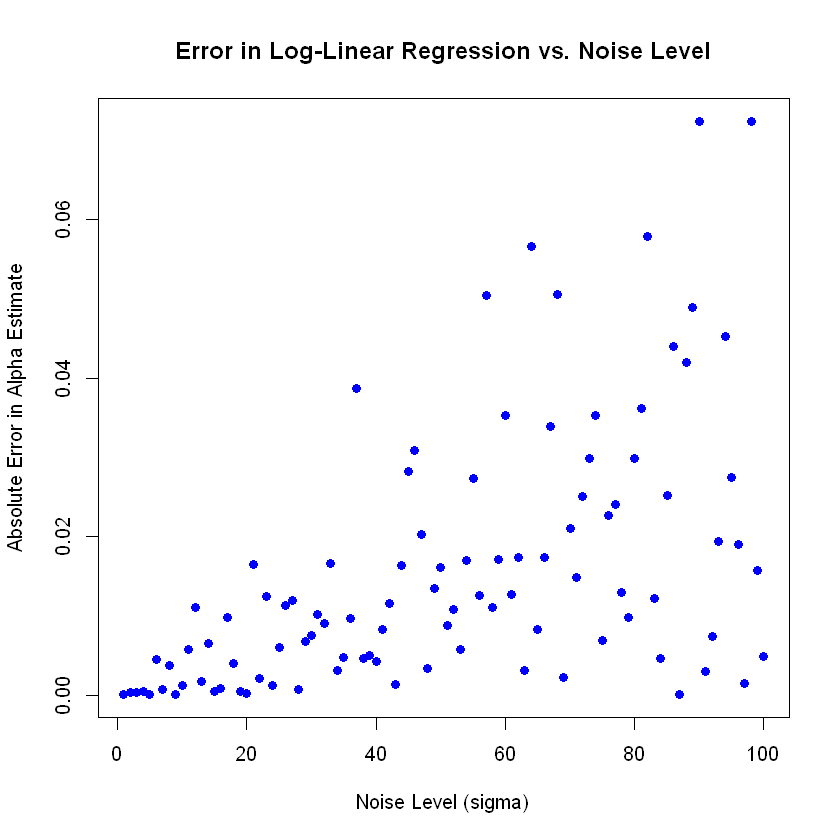

In [10]:
# Perform sweep over different noise levels
sigma_values <- seq(1, 100, by = 1)
error_values_log <- numeric(length(sigma_values))

for (i in 1:length(sigma_values)) {
  current_sigma <- sigma_values[i]
  
  # Generate new noise and observed clearance
  noise <- rnorm(Nobs, mean = 0, sd = current_sigma)
  C_observed <- C_theoretical + noise
  
  # Some noise values might make C_observed negative, which would make log undefined
  # Handle this by using only positive values
  valid_indices <- C_observed > 0
  
  if (sum(valid_indices) < 0.9 * Nobs) {
    # If too many negative values, skip this sigma
    error_values_log[i] <- NA
    next
  }

  # Create data frame for nls
  data <- data.frame(M = M, C = C_observed)

  # Fit nonlinear model
  # Start with reasonable initial values for parameters
  nls_model <- nls(C ~ k * M^alpha, data = data, 
                  start = list(k = 100, alpha = 0.7))

  # Get estimated parameters
  params <- coef(nls_model)
  k_estimated <- params["k"]
  alpha_estimated <- params["alpha"]
    
  # Calculate error
  error_values_log[i] <- abs(alpha_estimated - alpha_gt)
}

# Plot error vs sigma
par(bg = "white")
plot(sigma_values, error_values_log, 
     type = "p", 
     xlab = "Noise Level (sigma)", 
     ylab = "Absolute Error in Alpha Estimate",
     main = "Error in Log-Linear Regression vs. Noise Level",
     pch = 19,
     col = "blue")


We expect the true error to be smaller. Is it? By how much? For all values of $N_{\textrm{obs}}$?

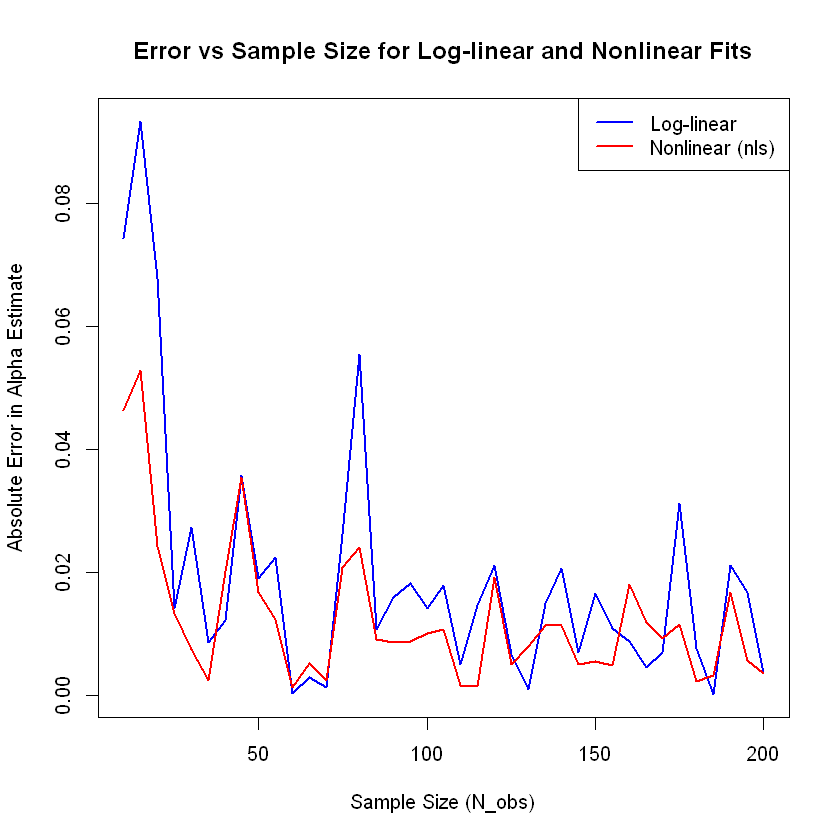

In [11]:
set.seed(123)

# Parameters
M_min <- 12
M_max <- 100
alpha_gt <- 0.68
C_max <- 1500
sigma <- 50  # fixed noise level for this experiment
N_values <- seq(10, 200, by = 5)

log_errors <- numeric(length(N_values))
nls_errors <- numeric(length(N_values))

for (i in seq_along(N_values)) {
  Nobs <- N_values[i]
  
  # Generate synthetic body masses
  M <- runif(Nobs, M_min, M_max)
  k_gt <- C_max / max(M)^alpha_gt
  C_theoretical <- k_gt * M^alpha_gt
  noise <- rnorm(Nobs, mean = 0, sd = sigma)
  C_observed <- C_theoretical + noise
  
  # -- Log-linear regression --
  valid_log <- C_observed > 0
  log_M <- log(M[valid_log])
  log_C <- log(C_observed[valid_log])
  log_model <- lm(log_C ~ log_M)
  alpha_log <- coef(log_model)[2]
  log_errors[i] <- abs(alpha_log - alpha_gt)
  
  # -- Nonlinear regression --
  data <- data.frame(M = M, C = C_observed)
  tryCatch({
    nls_model <- nls(C ~ k * M^alpha, data = data, 
                     start = list(k = 100, alpha = 0.7),
                     control = nls.control(warnOnly = TRUE))
    alpha_nls <- coef(nls_model)["alpha"]
    nls_errors[i] <- abs(alpha_nls - alpha_gt)
  }, error = function(e) {
    nls_errors[i] <- NA  # model didn't converge
  })
}

# Plot
par(bg = "white")
plot(N_values, log_errors, type = "l", col = "blue", lwd = 2,
     xlab = "Sample Size (N_obs)", ylab = "Absolute Error in Alpha Estimate",
     ylim = range(c(log_errors, nls_errors), na.rm = TRUE),
     main = "Error vs Sample Size for Log-linear and Nonlinear Fits")
lines(N_values, nls_errors, col = "red", lwd = 2)
legend("topright", legend = c("Log-linear", "Nonlinear (nls)"),
       col = c("blue", "red"), lwd = 2)

### Answer to question ii
In general, it seems that the nonlinear model generally achieves a smaller true error than the linear model, across all $N_{\text{obs}}$, with a trend of decreasing true errors for both models with increase in $N_{\text{obs}}$ (which is intuitively correct).

## Question iii

In the above, the synthetic data was provided for a sample of patients with uniformly-distributed masses. 

Informal question:
What is the most realisitic distribution of masses for a patient sample? 
For adult data? For pediatrics (children)?

Formal question:
Implement another distribution of patient masses, and repeat both log-transformed linear fit and non-linear fit.

* What distribution gives the largest discrepancy between the two methods? 
* What distribution gives the smallest discrepancy between the two methods?


In [12]:
# CODE HERE
set.seed(123)

# Define distributions
Nobs <- 100
alpha_gt <- 0.68
C_max <- 1500
sigma <- 50

get_M_samples <- list(
  Uniform = function() runif(Nobs, 12, 100),
  Normal_Truncated = function() pmax(rnorm(Nobs, mean = 70, sd = 15), 12),
  LogNormal = function() rlnorm(Nobs, meanlog = log(50), sdlog = 0.4),
  Gamma = function() rgamma(Nobs, shape = 9, rate = 0.12),  # mean ≈ 75
  Weibull = function() rweibull(Nobs, shape = 2, scale = 80),
  Beta_Scaled = function() 12 + 88 * rbeta(Nobs, 2, 5)  # rescale to [12,100]
)

results <- data.frame(
  Distribution = character(),
  Alpha_Log = numeric(),
  Alpha_NLS = numeric(),
  Abs_Diff = numeric(),
  stringsAsFactors = FALSE
)

for (dist_name in names(get_M_samples)) {
  M <- get_M_samples[[dist_name]]()
  k_gt <- C_max / max(M)^alpha_gt
  C_theoretical <- k_gt * M^alpha_gt
  noise <- rnorm(Nobs, mean = 0, sd = sigma)
  C_observed <- C_theoretical + noise
  
  # Log-linear regression
  valid_log <- C_observed > 0
  log_M <- log(M[valid_log])
  log_C <- log(C_observed[valid_log])
  log_model <- lm(log_C ~ log_M)
  alpha_log <- coef(log_model)[2]
  
  # Nonlinear regression
  data <- data.frame(M = M, C = C_observed)
  alpha_nls <- NA
  tryCatch({
    nls_model <- nls(C ~ k * M^alpha, data = data,
                     start = list(k = 100, alpha = 0.7),
                     control = nls.control(warnOnly = TRUE))
    alpha_nls <- coef(nls_model)["alpha"]
  }, error = function(e) {
    alpha_nls <- NA
  })
  
  # Record results
  results <- rbind(results, data.frame(
    Distribution = dist_name,
    Alpha_Log = alpha_log,
    Alpha_NLS = alpha_nls,
    Abs_Diff = abs(alpha_log - alpha_nls)
  ))
}

print(results[order(-results$Abs_Diff), ])


           Distribution Alpha_Log Alpha_NLS    Abs_Diff
log_M4          Weibull 0.7183126 0.6865329 0.031779742
log_M3            Gamma 0.7266262 0.7019957 0.024630497
log_M5      Beta_Scaled 0.7127717 0.6889739 0.023797768
log_M2        LogNormal 0.6686873 0.6810374 0.012350126
log_M1 Normal_Truncated 0.6974163 0.6881261 0.009290213
log_M           Uniform 0.6806565 0.6794571 0.001199382


### Answer to Question iii

- I believe the body mass, as a result of being sampled from a population should be normally distributed. For the difference in adult versus child mass data, I think adult data should be right-skewed (more heavier individuals) and the child data should be left skewed which is less heavier individuals. 
- For the following questions, we checked six different initial mass distributions. What we saw was the Weibull distribution showed the largest absolute difference between both models, while the Uniform distribution showed the least difference, a possible consequence of the fact that it fits the linear model the best, unlike other mass distributions.
